# AI 07a CIFAR-10 (Kaggle)



---


## YCS1003 CIFAR-10 Competition 2022-1

CIFAR-10은 32x32픽셀의 컬러이미지(RGB) 60000개로 이루어져 있으며

( training set - 50000, test set - 10000 )

각 이미지는 10개의 클래스로 구분되어있습니다.


주어진 SimpleCNN 모델의 구조와 하이퍼파라미터를 변경하며 성능을 향상시켜보고

CIFAR-10 dataset에 대한 예측값을 생성한 후 제출하세요.

- Kaggle에는 .csv 파일을 submit 하고 (ranking 생성)
- LearnUs 과제란 에는 .ipynb 파일을 제출


**[중요] 반드시 SimpleCNN 클래스 내부를 변경하여 사용해야 하며**

**Pretrained 모델을 사용하거나 인터넷 복붙코드를 가져오지 마세요.**

**본인이 구조를 변경하며 다양하게 시도한 흔적이 보이도록 주석으로 남겨주세요.**



Kaggle에 .csv 파일을 제출할 때
먼저 Team 탭에서 팀이름을 자신의 분반, 학번, 실명으로 변경 후 제출하세요. (청강생의 경우 '청강'을 추가)

1. 01분반 201812345 김연세

2. 02분반 201912345 이세연 (청강)


### 점수 기준은 다음과 같습니다. (Test accuracy)

- 65% 미만: 4점
- 65% 이상: 6점
- 73% 이상: 7점 (+1)
- 80% 이상: 8점 (+2)
- 87% 이상: 9점 (+3)
- 90% 이상: 10점 (+4)
- Pretrained 모델 등 주어진 SimpleCNN를 변경하는 방식이 아닌 경우: 2점
- 복붙 코드 등 Cheating: -5점
- 늦은 제출: 0점
- Competition에 제출하지 않고 LearnUs에만 제출: 0점


### Import packages
---

### 나의 변경일지

-
-
-


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T

import pickle


In [2]:
import argparse

In [3]:
# if __name__ == '__main__':
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--output-prefix')
#     parser.add_argument('--resume-from')
#     parser.add_argument('--input-dim', type=int)

#     args = parser.parse_args()

### Setup a device

In [4]:
# Device configuration

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('device:', device)

device: cuda


### Progress monitor
---

In [5]:
from IPython.display import HTML, display


# Custom IPython progress bar for training
class ProgressMonitor(object):
    
    tmpl = """
        <table style="width: 100%;">
            <tbody>
                <tr>
                    <td style="width: 30%;">
                     <b>Loss: {loss:0.4f}</b> &nbsp&nbsp&nbsp {value} / {length}
                    </td>
                    <td style="width: 70%;">
                        <progress value='{value}' max='{length}', style='width: 100%'>{value}</progress>
                    </td>
                </tr>
            </tbody>
        </table>        
        """

    def __init__(self, length):
        self.length = length
        self.count = 0
        self.display = display(self.html(0, 0), display_id=True)
        
    def html(self, count, loss):
        return HTML(self.tmpl.format(length=self.length, value=count, loss=loss))
        
    def update(self, count, loss):
        self.count += count
        self.display.update(self.html(self.count, loss))

### Load the datasets
---

In [6]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# data augmentation
transform_test = T.Compose( [T.ToTensor(), 
                             T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))] )

transform_train = T.Compose([
                            T.RandomAffine(30),
                            T.ColorJitter(),
                            T.RandomHorizontalFlip(),
                            T.ToTensor(),
                            T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_set = torchvision.datasets.CIFAR10('./data', train=True, download=True, transform=transform_train )
test_set = torchvision.datasets.CIFAR10('./data', train=False, download=True, transform=transform_test )



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
print(train_set.data.shape)
print(test_set.data.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


### Preview the data 
---

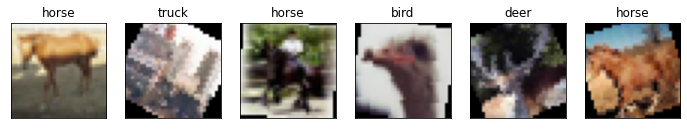

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def convert_to_imshow_format(image):
    # first convert back to [0,1] range from [-1,1] range
    image = image / 2 + 0.5
    image = image.numpy()
    # convert from CHW to HWC
    # from 3x32x32 to 32x32x3
    return image.transpose(1,2,0)

temp_loader = torch.utils.data.DataLoader(train_set, batch_size=30, shuffle=True)

dataiter = iter(temp_loader)
images, labels = dataiter.next()

images = images[:6]
labels = labels[:6]

fig, axes = plt.subplots(1, len(images), figsize=(12,2.5))
for idx, image in enumerate(images):
    axes[idx].imshow(convert_to_imshow_format(image))
    axes[idx].set_title(classes[labels[idx]])
    axes[idx].set_xticks([])
    axes[idx].set_yticks([])

### Specify a model architecture
---


In [9]:
# [ conv_layers 변경 예 1 ]

# self.conv_layers = nn.Sequential(
    
#     nn.Conv2d( in_channels=3, out_channels=32, kernel_size=3, padding=1 ), 
#     nn.BatchNorm2d(32),
#     nn.ReLU(),
#     nn.MaxPool2d(2), # 32, 32x32 -> 32, 16x16

#     nn.Conv2d( in_channels=32, out_channels=64, kernel_size=3, padding=1 ), # 32, 16x16 -> 64, 16x16
#     nn.BatchNorm2d(64),
#     nn.ReLU(),
#     nn.MaxPool2d(2), # 64, 16x16 -> 64, 8x8

# }


In [10]:

# SimpleCNN의 구조를 변경


class SimpleCNN(nn.Module) :

	def __init__(self) :
		super().__init__()

		# W, H = (N - F + 2P) / stride + 1
		# initial image size = 32 * 32

		self.conv_layers = nn.Sequential(

			# 3 32 32
			nn.Conv2d(3, 32, 3, 1, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
			nn.Dropout2d(0.3),
			nn.Conv2d(32, 32, 3, 1, padding=1), nn.BatchNorm2d(32), nn.ReLU(),

			nn.Conv2d(32, 64, 3, 1, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
			nn.Dropout2d(0.4),
			nn.Conv2d(64, 64, 3, 1, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
			nn.MaxPool2d(2, 2),

			# 64 16 16
			nn.Conv2d(64, 128, 3, 1, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
			nn.Dropout2d(0.5),
			nn.Conv2d(128, 128, 3, 1, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
			nn.MaxPool2d(2, 2),

			# 128 8 8
			nn.Conv2d(128, 256, 3, 1,padding = 1), nn.BatchNorm2d(256), nn.ReLU(),
			nn.Dropout2d(0.6),
			nn.Conv2d(256, 256, 3, 1,padding = 1), nn.BatchNorm2d(256), nn.ReLU(),
			nn.MaxPool2d(2, 2),

			#256 4 4
			nn.Conv2d(256, 512, 3, 1,padding = 1), nn.BatchNorm2d(512), nn.ReLU(),
			nn.Dropout2d(0.7),
			nn.Conv2d(512, 512, 3, 1,padding = 1), nn.BatchNorm2d(512), nn.ReLU(),
			nn.MaxPool2d(2, 2),


		)
  
		self.fc = nn.Sequential(
			
			nn.ReLU(),
			nn.Linear(512*2*2, 10, bias=True),
 
		)

		# self.initialize_weights()

	def forward(self, x) :
		features = self.conv_layers(x)
		flatten = torch.flatten(features, 1)  # flatten
		x = self.fc(flatten)
		return x


In [11]:
# Model test

# 배치사이즈 7
# RGB 3채널
# 이미지 사이즈 32x32
# 랜덤값의 입력 데이터를 모델에 통과시켜 결과 모양을 확인

temp = SimpleCNN()
output = torch.randn( 7, 3, 32, 32 )
# print( temp(output).size() )

print( temp.conv_layers(output).size() )

torch.Size([7, 512, 2, 2])


### Hyperparameters
---


In [12]:
batch_size = 512
learning_rate = 0.008
num_epochs = 1000

### Setup the data loaders
---


In [13]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

### Instantiate the model
---

In [14]:
model = SimpleCNN()

model.to(device)


SimpleCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.3, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Dropout2d(p=0.4, inplace=False)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(

### Train the model
---


In [15]:
# 변경 원하는 경우 변경 가능

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9, 0.99), eps=1e-07, weight_decay=0, amsgrad=False)
# optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.99), eps=1e-08, weight_decay=0.01, amsgrad=False, maximize=False)
optimizer = torch.optim.RAdam(model.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,
#                       momentum=0.95, weight_decay=3e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001,
#                       momentum=0.9, weight_decay=5e-4)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [17]:
from statistics import mean 
import sys 

def train(optimizer, model, num_epochs=10, first_epoch=1):
    
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    test_losses = []

    for epoch in range(first_epoch, first_epoch + num_epochs):
        print('Epoch', epoch)
        
        # train phase
        model.train()
        # create a progress bar
        progress = ProgressMonitor(length=len(train_set))
        
        # keep track of predictions
        correct_train = 0

        batch_losses = []

        # scheduler.step()  # ! lr scheduler
        
        for batch, targets in train_loader:
            
            # Move the training data to the GPU
            batch = batch.to(device)
            targets = targets.to(device)

            # clear previous gradient computation
            optimizer.zero_grad()

            # forward propagation
            outputs = model(batch)

            # calculate the loss
            loss = criterion(outputs, targets)

            # backpropagate to compute gradients
            loss.backward()

            # update model weights
            optimizer.step()

            batch_losses.append(loss.item())

            # accumulate correct count
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == targets.data)

            # update progress bar
            progress.update(batch.shape[0], mean(batch_losses) )  

        # scheduler.step()
        train_losses.append( mean(batch_losses))


        # test phase
        model.eval()

        y_pred = []

        correct_test = 0


        # We don't need gradients for test, so wrap in 
        # no_grad to save memory
        with torch.no_grad():

            for batch, targets in test_loader:

                # Move the training batch to the GPU
                batch = batch.to(device)
                targets = targets.to(device)

                # forward propagation
                outputs = model(batch)

                # calculate the loss
                loss = criterion(outputs, targets)

                # save predictions
                y_pred.extend( outputs.argmax(dim=1).cpu().numpy() )

                # accumulate correct count
                _, preds = torch.max(outputs, 1)
                correct_test += torch.sum(preds == targets.data)
                

        # Calculate accuracy
        train_acc = correct_train.item() / train_set.data.shape[0]
        test_acc = correct_test.item() / test_set.data.shape[0]

        print('Training accuracy: {:.2f}%'.format(float(train_acc) * 100))
        print('Test accuracy: {:.2f}%\n'.format(float(test_acc) * 100))
        
        # scheduler.step()
    
    return train_losses, test_losses, y_pred

### Checkpointing
---

In [21]:
train_losses, test_losses, y_pred = train(optimizer, model, num_epochs=num_epochs)

Epoch 1


Loss: 0.2956 50000 / 50000,50000


Training accuracy: 89.70%
Test accuracy: 89.75%

Epoch 2


Loss: 0.2994 50000 / 50000,50000


Training accuracy: 89.44%
Test accuracy: 90.06%

Epoch 3


Loss: 0.2947 50000 / 50000,50000


Training accuracy: 89.43%
Test accuracy: 89.70%

Epoch 4


Loss: 0.2960 50000 / 50000,50000


Training accuracy: 89.49%
Test accuracy: 89.98%

Epoch 5


Loss: 0.2962 50000 / 50000,50000


Training accuracy: 89.62%
Test accuracy: 89.73%

Epoch 6


Loss: 0.2951 50000 / 50000,50000


Training accuracy: 89.63%
Test accuracy: 89.95%

Epoch 7


Loss: 0.2950 50000 / 50000,50000


Training accuracy: 89.49%
Test accuracy: 89.84%

Epoch 8


Loss: 0.2936 50000 / 50000,50000


Training accuracy: 89.54%
Test accuracy: 89.68%

Epoch 9


Loss: 0.2933 50000 / 50000,50000


Training accuracy: 89.56%
Test accuracy: 89.50%

Epoch 10


Loss: 0.2962 50000 / 50000,50000


Training accuracy: 89.62%
Test accuracy: 89.73%

Epoch 11


Loss: 0.2930 50000 / 50000,50000


Training accuracy: 89.64%
Test accuracy: 89.76%

Epoch 12


Loss: 0.2900 50000 / 50000,50000


Training accuracy: 89.74%
Test accuracy: 89.64%

Epoch 13


Loss: 0.2881 50000 / 50000,50000


Training accuracy: 89.68%
Test accuracy: 89.51%

Epoch 14


Loss: 0.2860 50000 / 50000,50000


Training accuracy: 89.81%
Test accuracy: 90.02%

Epoch 15


Loss: 0.2917 50000 / 50000,50000


Training accuracy: 89.70%
Test accuracy: 89.83%

Epoch 16


Loss: 0.2925 50000 / 50000,50000


Training accuracy: 89.86%
Test accuracy: 89.53%

Epoch 17


Loss: 0.2935 50000 / 50000,50000


Training accuracy: 89.59%
Test accuracy: 89.61%

Epoch 18


Loss: 0.2893 50000 / 50000,50000


Training accuracy: 89.78%
Test accuracy: 90.01%

Epoch 19


Loss: 0.2852 50000 / 50000,50000


Training accuracy: 89.89%
Test accuracy: 90.05%

Epoch 20


Loss: 0.2834 4608 / 50000,4608


KeyboardInterrupt: ignored

### Make a CSV for submission
---

In [22]:

# test phase
model.eval()

# keep track of predictions
y_pred = []

# We don't need gradients for test, so wrap in 
# no_grad to save memory
with torch.no_grad():

    for batch, targets in test_loader:

        # Move the training batch to the GPU
        batch = batch.to(device)
        targets = targets.to(device)

        # forward propagation
        predictions = model(batch)

        # save predictions
        y_pred.extend( predictions.argmax(dim=1).cpu().numpy() )



In [23]:
import csv

def make_pred_csv(model):
    with open('cifar10_submit.csv', mode='w') as pred_file:
    
        pred_writer = csv.writer(pred_file, delimiter=',')
        pred_writer.writerow(['id', 'Category'])

        for i, label in enumerate(y_pred):
            pred_writer.writerow([i+1, classes[label]])
    

make_pred_csv(model)

## Kaggle에 제출 방법

---

#### 1) CSV Download

---


- 위의 Make a CSV for submission 항목의 코드들을 실행
- 왼쪽의 폴더 버튼을 클릭한 후 나오는 Files 패널에서 **cifar10_submit.csv** 확인
- 보이지 않을 경우 Refresh 클릭
- **cifar10_submit.csv** 오른쪽 클릭하여 다운로드


---

<img src="https://ycs-class.s3.ap-northeast-2.amazonaws.com/images/csv_download.png" width="400">


#### 2) Kaggle에 제출

---

- Kaggle 제출링크로 이동: https://www.kaggle.com/competitions/ycs1003-cifar-10-competition-2022-1/

<img src="https://esohn.be/images/kaggle1.png" width="500">

- Kaggle 계정이 없는 경우 register 있으면 login.

<img src="https://esohn.be/images/kaggle2.png" width="500">

- Team 탭을 클릭하여 먼저 이름을 분반 이름 학번으로 변경

<img src="https://esohn.be/images/kaggle3.png" width="500">

- 다운로드 했던 csv 파일을 제출

<img src="https://esohn.be/images/kaggle4.png" width="500">

---


